In [ ]:
%pip install tensorrt

In [1]:
from tensorflow import keras
import os
import io
import gc
import string
import numpy as np
from keras import backend as K
from keras import layers, models
from os import listdir
import random
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

2024-05-16 15:50:51.117257: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 15:50:54.806666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
def remove_files(dir):
    files = listdir(dir)
    for n, file in enumerate(files):
        os.remove(dir + '/' + file)

In [5]:
def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch in chars])

In [6]:
def clear_text(text):
    enabled_chars = 'абвгдежзийклмнопрстуфхцчшщьыъэюя!?., '
    cleared = text.lower()
    cleared = remove_chars_from_text(cleared, enabled_chars)
    return cleared

In [7]:
input_dir = 'test1'
# remove_files(input_dir + '/.ipynb_checkpoints')
# os.rmdir(input_dir + '/.ipynb_checkpoints')
file_list = listdir(input_dir)
datasets = list()
for n, file in enumerate(file_list[:50]):
    text = ''
    with io.open(input_dir + '/' + file, mode='r', encoding='utf-8') as f:
                try:
                    text = f.read()
                except Exception:
                    print('Can not read file', f)
    datasets.append(text)

In [8]:
X_train_text = [clear_text(text) for text in datasets]

len(X_train_text)

2

In [12]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(char_level=True)

tokenizer.fit_on_texts(X_train_text)

In [13]:
print(tokenizer.word_index)

{' ': 1, 'о': 2, 'е': 3, 'а': 4, 'и': 5, 'т': 6, 'н': 7, 'р': 8, 'с': 9, 'л': 10, 'в': 11, 'к': 12, 'д': 13, 'м': 14, 'у': 15, 'я': 16, 'ы': 17, 'ъ': 18, 'г': 19, 'й': 20, 'з': 21, 'б': 22, 'ч': 23, ',': 24, 'п': 25, 'х': 26, 'ж': 27, 'ю': 28, '.': 29, 'ш': 30, 'щ': 31, 'ц': 32, 'ф': 33, 'э': 34, 'ь': 35, '?': 36, '!': 37}


In [14]:
%%time

seq_length = 20
X_train, Y_train = [], []

for text in X_train_text[:6000]:
    for i in range(0, len(text) - seq_length):
        inp_seq = text[i:i + seq_length]
        X_train.append(inp_seq)
        out_seq = text[i + seq_length]
        Y_train.append(tokenizer.word_index[out_seq])

X_train = tokenizer.texts_to_sequences(X_train)

X_train, Y_train = np.array(X_train, dtype=np.int32).reshape(-1, seq_length,1), np.array(Y_train)

X_train.shape, Y_train.shape

CPU times: user 1.31 s, sys: 23 ms, total: 1.33 s
Wall time: 1.33 s


((204771, 20, 1), (204771,))

In [60]:
def random_idx():
    random.seed(100)
    return random.randint(0, len(X_train))

In [16]:
def get_initial_pattern_by_indx(idx : int):
    return X_train[idx].flatten().tolist()

In [17]:
def get_text_from_indx(idx, array):
    return "".join([tokenizer.index_word[idx] for idx in array]);

In [38]:
def generate_ans(length = 100):
    ans = ""
    idx = random_idx()
    pattern = get_initial_pattern_by_indx(idx)
    generated_text = []
    ans = ans + "Начальный текст : {}".format("".join([tokenizer.index_word[idx] for idx in pattern]))
    for i in range(length):
        X_batch = np.array(pattern, dtype=np.int32).reshape(1, seq_length)
        preds = model.predict(X_batch)
        predicted_index = preds.argmax(axis=-1)[0]
        generated_text.append(predicted_index)
        pattern.append(predicted_index)
        pattern = pattern[1:]
    ans = ans + "\nСгенерированный текст : {}".format("".join([tokenizer.index_word[idx] for idx in generated_text]))
    print(ans)

In [19]:
gc.collect()

48

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

embed_len = 20
lstm_out = 256

model = Sequential([
                    Embedding(len(tokenizer.word_index)+1, output_dim=embed_len, input_length=seq_length),
                    LSTM(lstm_out, input_shape=(seq_length, 1), return_sequences=True),
                    LSTM(lstm_out),
                    Dense(len(tokenizer.word_index) + 1, activation="softmax")
                ])

model.summary()

2024-05-16 15:52:38.479887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79259 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:8c:00.0, compute capability: 8.0
2024-05-16 15:52:39.876371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 15:52:39.877437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/s

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 20)            760       
                                                                 
 lstm (LSTM)                 (None, 20, 256)           283648    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 38)                9766      
                                                                 
Total params: 819,486
Trainable params: 819,486
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy")

In [22]:
history = model.fit(X_train, Y_train, batch_size=1024, epochs=10)

Epoch 1/10


2024-05-16 15:52:44.796322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 15:52:44.798463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 15:52:44.800322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

200/200 [==============================] - 5s 7ms/step - loss: 3.2052
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 3.0591
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 2.7394
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 2.6850
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 2.6570
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 2.6364
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 2.6221
Epoch 8/10
200/200 [==============================] - 1s 6ms/step - loss: 2.6127
Epoch 9/10
200/200 [==============================] - 1s 6ms/step - loss: 2.6068
Epoch 10/10
200/200 [==============================] - 1s 6ms/step - loss: 2.6030


In [23]:
generate_ans()

2024-05-16 15:54:08.683799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 15:54:08.685197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 15:54:08.687067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 18ms/step
Начальный текст : нашенатил шъ гретане
Сгенерированный текст :  на на на на на на на на на на на на на на на на на на на на на на на на на на на на на на на на на 


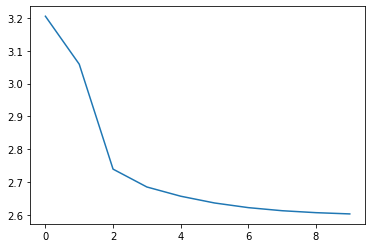

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.show()

In [25]:
input_dir = 'Пушкин'
# remove_files(input_dir + '/.ipynb_checkpoints')
# os.rmdir(input_dir + '/.ipynb_checkpoints')
file_list = listdir(input_dir)
datasets = list()
for n, file in enumerate(file_list[:7]):
    text = ''
    with io.open(input_dir + '/' + file, mode='r', encoding='utf-8') as f:
                try:
                    text = f.read()
                except Exception:
                    print('Can not read file', f)
    datasets.append(text)

In [26]:
X_train_text = [clear_text(text) for text in datasets]

len(X_train_text)

7

In [43]:
%%time

seq_length = 20
X_train, Y_train = [], []

for text in X_train_text:
    for i in range(0, len(text) - seq_length):
        inp_seq = text[i:i + seq_length]
        X_train.append(inp_seq)
        out_seq = text[i + seq_length]
        Y_train.append(tokenizer.word_index[out_seq])

X_train = tokenizer.texts_to_sequences(X_train)

X_train, Y_train = np.array(X_train, dtype=np.int32).reshape(-1, seq_length,1), np.array(Y_train)

X_train.shape, Y_train.shape

CPU times: user 400 ms, sys: 5.79 ms, total: 406 ms
Wall time: 404 ms


((80956, 20, 1), (80956,))

In [28]:
K.set_value(model.optimizer.learning_rate, 0.0001)
history = model.fit(X_train, Y_train, batch_size=1024, epochs=10)

Epoch 1/10
80/80 [==============================] - 1s 8ms/step - loss: 2.7359
Epoch 2/10
80/80 [==============================] - 1s 6ms/step - loss: 2.5659
Epoch 3/10
80/80 [==============================] - 1s 6ms/step - loss: 2.5012
Epoch 4/10
80/80 [==============================] - 1s 8ms/step - loss: 2.4603
Epoch 5/10
80/80 [==============================] - 1s 6ms/step - loss: 2.4275
Epoch 6/10
80/80 [==============================] - 0s 6ms/step - loss: 2.3983
Epoch 7/10
80/80 [==============================] - 1s 6ms/step - loss: 2.3718
Epoch 8/10
80/80 [==============================] - 1s 6ms/step - loss: 2.3481
Epoch 9/10
80/80 [==============================] - 1s 6ms/step - loss: 2.3262
Epoch 10/10
80/80 [==============================] - 1s 6ms/step - loss: 2.3062


In [30]:
generate_ans()

1/1 [==============================] - 0s 21ms/step
Начальный текст :  любовалась и диву д
Сгенерированный текст : аль он сто постали в от постой не сторе простала в от постой не сторе простала в от постой не сторе 


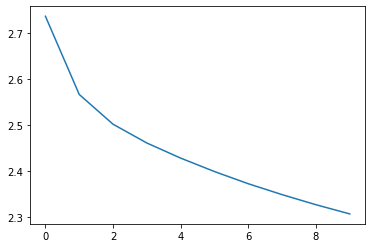

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.show()

In [32]:
K.set_value(model.optimizer.learning_rate, 0.0003)
history = model.fit(X_train, Y_train, batch_size=1024, epochs=20)

Epoch 1/20
80/80 [==============================] - 1s 7ms/step - loss: 2.2819
Epoch 2/20
80/80 [==============================] - 1s 6ms/step - loss: 2.2365
Epoch 3/20
80/80 [==============================] - 1s 6ms/step - loss: 2.1926
Epoch 4/20
80/80 [==============================] - 1s 6ms/step - loss: 2.1529
Epoch 5/20
80/80 [==============================] - 1s 6ms/step - loss: 2.1137
Epoch 6/20
80/80 [==============================] - 1s 6ms/step - loss: 2.0784
Epoch 7/20
80/80 [==============================] - 1s 6ms/step - loss: 2.0445
Epoch 8/20
80/80 [==============================] - 1s 8ms/step - loss: 2.0125
Epoch 9/20
80/80 [==============================] - 1s 6ms/step - loss: 1.9814
Epoch 10/20
80/80 [==============================] - 1s 6ms/step - loss: 1.9519
Epoch 11/20
80/80 [==============================] - 1s 6ms/step - loss: 1.9256
Epoch 12/20
80/80 [==============================] - 1s 6ms/step - loss: 1.8987
Epoch 13/20
80/80 [==============================

In [33]:
generate_ans()

1/1 [==============================] - 0s 18ms/step
Начальный текст :  любовалась и диву д
Сгенерированный текст : оловой полетели в том постой, постой, под не море сторо стол под нестольно стали в только поднялась 


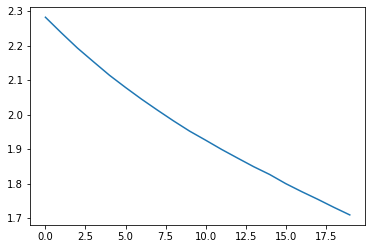

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.show()

In [36]:
K.set_value(model.optimizer.learning_rate, 0.0001)
history = model.fit(X_train, Y_train, batch_size=1024, epochs=20)

Epoch 1/20
80/80 [==============================] - 1s 7ms/step - loss: 1.6756
Epoch 2/20
80/80 [==============================] - 1s 6ms/step - loss: 1.6653
Epoch 3/20
80/80 [==============================] - 1s 6ms/step - loss: 1.6572
Epoch 4/20
80/80 [==============================] - 1s 6ms/step - loss: 1.6490
Epoch 5/20
80/80 [==============================] - 1s 6ms/step - loss: 1.6413
Epoch 6/20
80/80 [==============================] - 1s 6ms/step - loss: 1.6339
Epoch 7/20
80/80 [==============================] - 1s 6ms/step - loss: 1.6262
Epoch 8/20
80/80 [==============================] - 1s 6ms/step - loss: 1.6187
Epoch 9/20
80/80 [==============================] - 1s 6ms/step - loss: 1.6111
Epoch 10/20
80/80 [==============================] - 1s 8ms/step - loss: 1.6033
Epoch 11/20
80/80 [==============================] - 1s 6ms/step - loss: 1.5965
Epoch 12/20
80/80 [==============================] - 1s 6ms/step - loss: 1.5891
Epoch 13/20
80/80 [==============================

In [37]:
generate_ans()

1/1 [==============================] - 0s 19ms/step
Начальный текст :  любовалась и диву д
Сгенерированный текст : оловой полетел на простоле и воле тот и с свот их вор не стол не стольно и в семером на предел но се


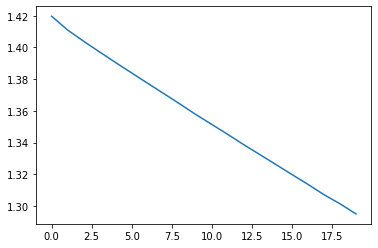

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.show()

In [39]:
model.save('models/SytheAndPuskin.keras')

In [41]:
generate_ans(1000)

1/1 [==============================] - 0s 19ms/step
Начальный текст :  любовалась и диву д
Сгенерированный текст : оловой полетел на простоле и воле тот и с свот их вор не стол не стольно и в семером на предел но сере слезе долго с нам обрось не слышал с ней на сере своей оброк не слышком под свой постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, постой, посто

In [54]:
first = [2.7359,2.5659,2.5012,2.4603,2.4275,2.3983,2.3718,2.3481,2.3262,2.3062]
second = [3.1655,3.1111,2.9956,2.7383,2.5803,2.5172,2.4670,2.4131,2.3594,2.3102]

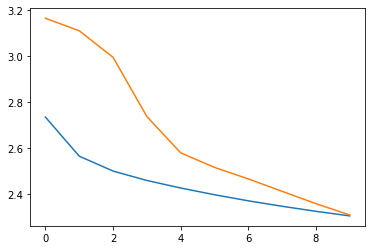

In [55]:
import matplotlib.pyplot as plt

plt.plot(first, label='line 1')
plt.plot(second, label='line 2')
plt.show()

In [56]:
first = [2.2819,2.2365,2.1926,2.1529,2.1137,2.0784,2.0445,2.0125,1.9814,1.9519,1.9256,1.8987,1.8736,1.8488,1.8261,1.7997,1.7764,1.7543,1.7311,1.7090]
second = [2.2492,2.2257,2.2062,2.1854,2.1646,2.1444,2.1236,2.1048,2.0834,2.0653,2.0448,2.0253,2.0040,1.9847,1.9665,1.9446,1.9267,1.9056,1.8854,1.8656]

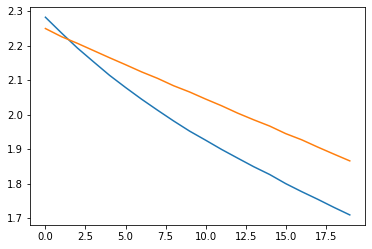

In [57]:
import matplotlib.pyplot as plt

plt.plot(first, label='line 1')
plt.plot(second, label='line 2')
plt.show()

In [58]:
first = [1.6756,1.6653,1.6572,1.6490,1.6413,1.6339,1.6262,1.6187,1.6111,1.6033,1.5965,1.5891,1.5815,1.5741,1.5667,1.5600,1.5525,1.5453,1.5375,1.5304]
second = [1.8351,1.8253,1.8176,1.8105,1.8026,1.7950,1.7881,1.7806,1.7735,1.7658,1.7589,1.7513,1.7439,1.7372,1.7296,1.7224,1.7153,1.7078,1.7004,1.6933]

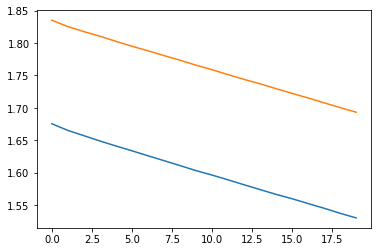

In [59]:
import matplotlib.pyplot as plt

plt.plot(first, label='line 1')
plt.plot(second, label='line 2')
plt.show()

In [44]:
%%time

seq_length = 100
X_train, Y_train = [], []

for text in X_train_text:
    for i in range(0, len(text) - seq_length):
        inp_seq = text[i:i + seq_length]
        X_train.append(inp_seq)
        out_seq = text[i + seq_length]
        Y_train.append(tokenizer.word_index[out_seq])

X_train = tokenizer.texts_to_sequences(X_train)

X_train, Y_train = np.array(X_train, dtype=np.int32).reshape(-1, seq_length,1), np.array(Y_train)

X_train.shape, Y_train.shape

CPU times: user 1.78 s, sys: 3.48 ms, total: 1.78 s
Wall time: 1.77 s


((80396, 100, 1), (80396,))

In [45]:
K.set_value(model.optimizer.learning_rate, 0.0001)
history = model.fit(X_train, Y_train, batch_size=1024, epochs=10)

Epoch 1/10


2024-05-16 16:22:40.726523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 16:22:40.728711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 16:22:40.730070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

79/79 [==============================] - 3s 24ms/step - loss: 1.5798
Epoch 2/10
79/79 [==============================] - 2s 24ms/step - loss: 1.5495
Epoch 3/10
79/79 [==============================] - 2s 24ms/step - loss: 1.5382
Epoch 4/10
79/79 [==============================] - 2s 23ms/step - loss: 1.5298
Epoch 5/10
79/79 [==============================] - 2s 23ms/step - loss: 1.5222
Epoch 6/10
79/79 [==============================] - 2s 24ms/step - loss: 1.5145
Epoch 7/10
79/79 [==============================] - 2s 23ms/step - loss: 1.5067
Epoch 8/10
79/79 [==============================] - 2s 24ms/step - loss: 1.4988
Epoch 9/10
79/79 [==============================] - 2s 24ms/step - loss: 1.4916
Epoch 10/10
79/79 [==============================] - 2s 23ms/step - loss: 1.4838


In [47]:
generate_ans(1000)

1/1 [==============================] - 0s 21ms/step
Начальный текст : лечку. я поскорее дверью хлоп и спряталась за печку. вот слышу много голосов... взошли двенадцать мо
Сгенерированный текст : лодой, и сладеть не смешли не свете с нам оброк уж не стой богаты, и с ним он бесенок на полетел на пред верном оброк себе постой, в свете ж вот ты мой приговорит он на бесенок полетели в том гости меня себе в полее молодить не смешли не смерть и с ними долго с нами страдался на половой полетел и в сердце проситель ты мой прекрасный, с нам оброк на сере волна и в сердце пристали в приставиет и приставил он не светел себе в свете ж вот как дель тобя свой под корой оброк нам оброк на сере волна молодить не смешь тебе поклонилась и с намит он прислал тебе поклонилась и с нами с нами страна поднялась и в сердце простить и с ними долго с нами страдался на половой полетел и в сердце проситель ты мой прекрасный, с нам оброк на сере волна и в сердце пристали в приставиет и приставил он не светел себе в

In [52]:
K.set_value(model.optimizer.learning_rate, 0.0003)
history = model.fit(X_train, Y_train, batch_size=1024, epochs=20)

Epoch 1/20
79/79 [==============================] - 2s 23ms/step - loss: 1.4924
Epoch 2/20
79/79 [==============================] - 2s 23ms/step - loss: 1.4711
Epoch 3/20
79/79 [==============================] - 2s 23ms/step - loss: 1.4517
Epoch 4/20
79/79 [==============================] - 2s 24ms/step - loss: 1.4295
Epoch 5/20
79/79 [==============================] - 2s 23ms/step - loss: 1.4086
Epoch 6/20
79/79 [==============================] - 2s 24ms/step - loss: 1.3874
Epoch 7/20
79/79 [==============================] - 2s 24ms/step - loss: 1.3644
Epoch 8/20
79/79 [==============================] - 2s 24ms/step - loss: 1.3420
Epoch 9/20
79/79 [==============================] - 2s 24ms/step - loss: 1.3192
Epoch 10/20
79/79 [==============================] - 2s 24ms/step - loss: 1.2965
Epoch 11/20
79/79 [==============================] - 2s 24ms/step - loss: 1.2747
Epoch 12/20
79/79 [==============================] - 2s 24ms/step - loss: 1.2516
Epoch 13/20
79/79 [==================

In [53]:
generate_ans(5000)

1/1 [==============================] - 0s 20ms/step
Начальный текст : лечку. я поскорее дверью хлоп и спряталась за печку. вот слышу много голосов... взошли двенадцать мо
Сгенерированный текст : лодцов, и с светом доном посланный дук то же день и на бес не слезно было будь голово. ты молодцо, скажи, под ковой блестит, а опять пришли твои на пред его в свете ж вот какое чудо остров на море лежит, бедный приво не станко было бадосто смерть не мог по славет. нет, скажи, так на подбор стал слезы долго с нами строготой оброк из море все другомой, с нами чтобим ты море полятельный довой злодейство на бес весело берег выславой поконились на берег с нами старойсь корабли по ней не брата иль и следить за смерти и сидела с ней милого лебе весь светлид во всем меня себя расплава к ней пришли дарь салье, в свет ей девицу оброк лишь об едром наместричай. не привальный да не душа скоречил.  нать в нами салтану да сам посланет, не права славною девица, с ним море понетели отет, что приведно и в свете

In [61]:
generate_ans(1000)

1/1 [==============================] - 0s 20ms/step
Начальный текст : топишь берег ты земли, подымаешь корабли  не губи ты нашу душу выплесни ты нас на сушу! и послушалас
Сгенерированный текст : ь воледит он с нами сказала, и в собраменной закон. на поднят, а самой под косой блестит, а он бежит меня на приведливо пок дивой, гости будет он на море скажи да сам передут мой собой бесенок да постой, словой стречней молвили и белая меня на свет иль свет золотой и прости его положиет и в праву море пристали в приставиет он с поварихой на простове вестросным наконец с нам полетел на краса сказать во все ж в не был оброк на сере бесенок удела так и так диво приближали в семе прославил, но сам только пришли толит, а сидит во всем меня в нем горед не брат, клявдонь три пораду не стали в пристанье молодые, все приветствуй бесенок да с мой пришел с пору не скорей отец стол своей он положи тебе польшой, по морю по окияну к славному царю салтану да скажите с невестоко меня я свой подлянушку положили